<div class="report-header"><div class="aictx-logo"></div>
<span class="report-type">Documentation</span><br />
<span class="report-author">Author: Felix Bauer</span><br />
<span class="report-date">5th October, 2018</span>
</div><h1>FFExpSyn and FFExpSynTorch:</h1><h1>Layers of exponential synapses</h1>

This document illustrates how to use the `FFExpSyn` (Exponential Synapse) layer and its equivalent `FFExpSynTorch`. Regarding their functionality and use these layers are the same, but the latter is based on `PyTorch` and therefore allows running on the GPU if CUDA is available. 

Each layers' neurons consist of synapses that receive spiking input, which they weigh and filter with an exponential kernel. It is particularly useful for converting spike trains to analogue signals.

##### Housekeeping and import statements


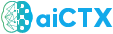

In [1]:
# - Import required modules and configure; set report style 

import os, sys
strToolboxPath = os.path.abspath("../../")
if strToolboxPath not in sys.path:
    sys.path.append(strToolboxPath)
    
# - Initialisation code to include custom report styles
from IPython.core.display import HTML
def css_styling():
    styles = open("aictx-report.css", "r").read()
    return HTML(styles)
css_styling()

## Neuron model

### State evolution

Both layers consists of `size` neurons and receives an `size_in`-dimensional spiking input. Each neuron receives a lincear combination of the input spike trains and applies an exponentially decaying filter with time constant `tau_syn` ($\tau$), effectively low-pass filtering them. This can be interpreted as a group of exponential synapses, without any subsequent neural dynamics or, conversely, as leaky integrator neurons without any synaptic dynamics and spiking. For clock-based simulations this is equivalent to applying exponential smoothing to linear combinations of spike trains, with smoothing factor $\frac{\Delta}{\tau}$, where $\Delta$ is the clock step `dt`.

Formaly, the neurons' states are described by the vector $\mathbf{v}$ (`state`). Let the input spike train to the layer be $\mathbf{S}_t$. For each time point $t$, its components give the number of incoming spikes on the corresponding channel. Then the neuron states $\mathbf{v}$ evolve according to
$$ \mathbf{\tilde{v}}_t = \mathbf{\tilde{v}}_{t-1} + \frac{\Delta}{\tau} \cdot W_{in} \cdot \mathbf{S}_{t -1}  + \mathbf{\sigma}_t $$
$$ \mathbf{v}_t = \mathbf{\tilde{v}}_t + \mathbf{v}_{bias}$$
Here, $W_{in}$ (`weights_in`) is the `size_in` x `size` input weight matrix and $\mathbf{v}_{bias}$ (`bias`) is a bias vector. $\mathbf{\sigma}_t$ is a vector of independently drawn samples from a Gaussian distribution with mean 0 and a standard deviation $\tilde{s}$, that is chosen such that the states of otherwise identical neurons after one second have a standard deviation of $s$ (`noise_std`). This is achieved with $\tilde{s} = s \cdot \sqrt{\frac{2\Delta}{\tau}}$.

<br>

## Import

In [2]:
# - Import FFExpSyn layer
from NetworksPython.layers import FFExpSyn
# - Import FFExpSynTorch layer
from NetworksPython.layers import FFExpSynTorch

/home/felix/miniconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


<br>

## Instantiation
`FFExpSyn` and `FFExpSynTorch` objects are instantiated with the following arguments:

| Argument | Type | Default | Meaning |
|----------|------|---------|---------|
| `weights_in` | 2D-`ndarray` | - | Input weights (required) |
| `bias` | `ArrayLike` or `float` | 0 | Constant bias |
| `dt` | `float` | 0.0001 | Time step |
| `noise_std` | `float` | 0 | Noise standard deviation |
| `tau_syn` | `float` | 0.005 | Filter time constant |
| `name` | `str` | "unnamed" | Layer name |
| `add_events` | `bool` | False | Add multiple input spikes in single time step |
| `nDefaultMaxNumTimeSteps` | `int` | 5000 | Length of batches that evolve is split into (only `FFExpSynTorch`) |

The matrix `weights_in` sets the input weights and has to be provied. It defines the layer dimensions by its shape (`size_in`x`size`).

`bias` contains the biases for each neuron and is added to the layer output. It can either be an array-like object of size `size` or a single `float` which is then applied to all neurons. `dt` is a positive `float` that determines the size of a single evolution time step. `tau_syn` is the time constant with which the input spikes are filtered. `noise_std` is the standard deviation that identical neurons will show after one second of evolution, due to noise. `name` is a string that defines the layer's name.  For `FFExpSynTorch` a boolean argument `add_events` can be passed. Setting it to true makes sure that during evolution and training input all the spikes are counted, even if some of them arrive at the same time step and channel. This makes it possible to have a larger `dt` than the layer from which the input is received without losing input spikes.

All of these values can be accessed and changed via `<Layer>.value`, where `<Layer>` is the instance of the layer.

<br>

## Evolution

The `evolve` method takes the standard arguments `ts_input`, `duration`, `num_timesteps` and `verbose`, which is currently not being used. Evolution duration is determined by the usual rules. If `ts_input` is provided, it must be a `TSEvent` object. Its `raster` method is then used to generate a boolean spike raster, over which the evolution will iterate.

Neurons will evolve as described above. The method will return a `TSContinuous` object containing the neuron states for each simulation time step.

<br>

## Resetting

The layer's time and state can be reset by the `reset_time`, `reset_state` and `reset_all` methods. When resetting the state, `state` is set to 0.

<br>

## Training

`FFExpSyn` and `FFExpSynTorch` are usually used as readout layers whose biases and weights need to be trained. Both classes provide a method `train_rr` for training with ridge regression. 

<br>

## Internal methods (WIP)

```
_prepare_input(
    ts_input: Optional[TSEvent] = None,
    duration: Optional[float] = None,
) -> (np.ndarray, float)
```
Called by evolve, which passes it its `ts_input` and `duration` arguments. `_prepare_input` will create a 2D boolean array from `ts_input`, determine the correct evolution duration and return this.

```
_add_to_record(
    state_time_series: list,
    t_now: float,
    id_out: Union[ArrayLike, bool] = True,
    state: Optional[np.ndarray] = None,
    debug: bool = False,
)
```
Called by evolve before and after spikes at each evolution time step if `monitor_id` is not `False` or `None`. For each element `i` in `id_out` it appends to `aSTateTimeSeries` a list consisting of `t_now`, `i` and the state of the neuron with corresponding ID. If `id_out` is `True`, every neuron's state is appended, if it is `False`, nothing is done. Neuron states are taken from the `state` argument or, if it is `None`, from `<Layer>.state`. If `debug == True`, the recorded states are printed out.

<br>

## Class member overview (WIP)

<br>

### Methods

| arguments: | Description |
|--------|-------------|
| `_add_to_record` | Record neuron states to a list |
| `_prepare_input` | Sample input data, determine evolution duration |
| `evolve` | Evolve layer |
| `reset_all` | Reset neuron states and layer time|
| `reset_state` | Reset neuron states |
| `reset_time` | Reset layer time to 0 |
| `randomize_state` | Randomize neuron states to values between 0 and 1 |
<i> Internal methods of parent class</i> `Layer` <i> are listed in corresponding documentation. </i>

<br>

### Attributes

Each argument that described in section Instantiation has a corresponding attribute that can be accessed by `<Layer>.<attribute>`, where `<Layer>` is the layer instance and `<attribute>` the argument name. Furthermore there are a few internal attributes:

| Attribute name | Description |
|----------------|-------------|
| `_ts_state` | Array of recorded neuron states from previous evolution. Does only exist if `evolution` has been called at least once. |
| `_vnNumRecSpikes` | (Only `RecCLIAF`) Vector of size `size` that contains for each neuron the number of spikes it has emitted in the last time step of the previous evolution. They will be processed in the first time step of the next evolution. |

#### Colophon
Live notebook requires a Jupyter Notebook server.

GitLab repository location: https://gitlab.com/ai-ctx/network-architectures/blob/master/Projects/Documentation/FFCLIAF%20and%20RecCLIAF.ipynb